## Segmentacja komórek śródbłonka rogówki z obrazów mikroskopowych

Zadanie polega na segmentacji obrazów śródbłonka rogówki przy użyciu dwóch metod: segmentacji działów wodnych (watershed) oraz segmentacji błądzenia losowego (random walker).

### Dane
Mamy dostęp do 4 obrazów:
- `image.png` - obraz oryginalny
- `gt.png` - maska ręcznie oznaczonych komórek
- `markers.png` - maska z oznaczonymi centrami komórek
- `roi.png` - maska obszaru zainteresowania, tylko w tym obszarze wydobędziemy komórki

### Watershed
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html

Zaimplementuj funkcję `segmentation_with_watershed`, która przyjmuje obraz oryginalny, maskę z oznaczonymi centrami komórek oraz maskę obszaru zainteresowania.

Funkcja ma zwracać krawędzie komórek.

Obraz przed segmentacją można rozmyć np. filtrem Gaussa.

UWAGA: funkcja `watershed` powinna otrzymać obraz ujemny (np. `-image`)

Do uzyskania markerów wymaganych przez funkcję `skimage.segmentation.watershed` wykorzystaj funkcję `skimage.morphology.label`.
Krawędzie można uzyskać poprzez argument `watershed_line=True` funkcji `skimage.segmentation.watershed`, lub poprzez ustawienie `watershed_line=False` (zalecane) i użycie funkcji tj.:
- `skimage.filters.sobel` (wymagana binaryzacja)
- `skimage.filters.roberts` (wymagana binaryzacja)
- `skimage.segmentation.find_boundaries` (zalecana)

Dokonaj szkieletyzacji wyników (`skimage.morphology.skeletonize`), a następnie użyj dylacji z elementem kwadratowym o rozmiarze 4x4 (np. `skimage.morphology.square(4)`).

Porównaj wyniki z maską ręcznie oznaczonych komórek - oblicz miarę IoU (Intersection over Union).

### Random walker
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_random_walker_segmentation.html

Zaimplementuj funkcję `segmentation_with_random_walker`, która przyjmuje obraz oryginalny, maskę z oznaczonymi centrami komórek oraz maskę obszaru zainteresowania.

Funkcja ma zwracać krawędzie komórek.

UWAGA: funkcja `random_walker` jest bardzo wolna. 

Do uzyskania markerów wymaganych przez funkcję `skimage.segmentation.random_walker` wykorzystaj funkcję `skimage.morphology.label`.

Funkcja `random_walker` jest dość wolna, więc zalecam skorzystać z tych parametrów:
- `beta=5`
- `mode='bf'`
- `tol=0.1`

Co więcej należy pomnożyć maskę obszaru zainteresowania z obrazem, aby od razu ograniczyć obszar segmentacji w funkcji `random_walker`.

Aby uzyskać krawędzie wykorzystaj jedną z tych metod:
- `skimage.filters.sobel` (wymagana binaryzacja)
- `skimage.filters.roberts` (wymagana binaryzacja)
- `skimage.segmentation.find_boundaries` (zalecana)

Dokonaj szkieletyzacji wyników (`skimage.morphology.skeletonize`), a następnie użyj dylacji z elementem kwadratowym o rozmiarze 4x4 (np. `skimage.morphology.square(4)`).


IoU watershed:  0.8058661990471149


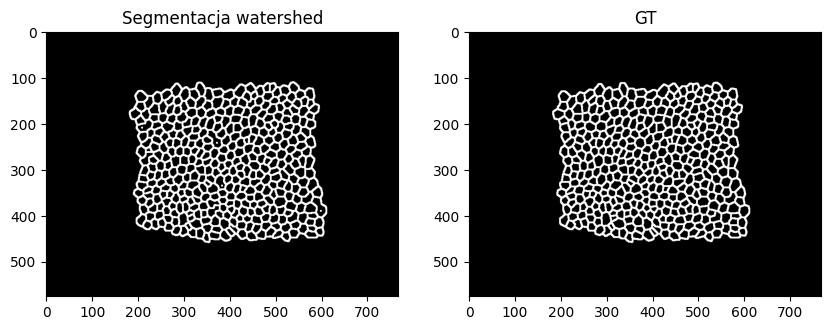

IoU random walker:  0.7306329033082131


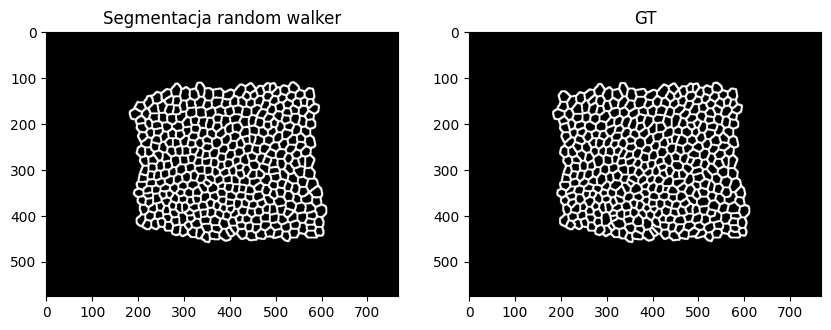

In [1]:
import numpy as np
import skimage.io
from skimage import morphology, segmentation, measure, filters
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from skimage.morphology import label,skeletonize
from skimage.segmentation import watershed, find_boundaries
from skimage.morphology import dilation, square
from skimage.segmentation import random_walker
from skimage.segmentation import watershed

def IoU(x: np.ndarray, y: np.ndarray, roi: np.ndarray = None) -> float:
    assert x.shape == y.shape

    x = x.astype(bool)
    y = y.astype(bool)

    if roi is not None:
        x = x * roi
        y = y * roi

    intersection = np.logical_and(x, y).sum()
    if intersection == 0:
        return 0
    union = np.logical_or(x, y).sum()
    if union == 0:
        return 0
    return intersection / union


def segmentation_with_watershed(image: np.ndarray, markers: np.ndarray, roi: np.ndarray | None = None) -> np.ndarray:
    # Umieść swój kod tutaj
    image_gauss = gaussian(image, sigma=2)
    markers = label(markers)

    water = watershed(-image_gauss, markers, mask=roi, watershed_line=False)

    boundaries = find_boundaries(water)
    skeleton = skeletonize(boundaries)
    dilated_boundaries = dilation(skeleton, square(4))

    return dilated_boundaries
    pass


def segmentation_with_random_walker(image: np.ndarray, markers: np.ndarray, roi: np.ndarray | None = None) -> np.ndarray:
    # Umieść swój kod tutaj

    image_gauss = gaussian(image, sigma=1)

    markers_l = label(markers)
    img = image_gauss * roi

    segmented = random_walker(img,markers_l,beta = 5,mode ='bf',tol=0.1)
    
    bound = find_boundaries(segmented)
    skel_img = skeletonize(bound)
    dilate_bound = dilation(skel_img,square(4))

    return dilate_bound
    pass

if __name__ == "__main__":
    image = skimage.io.imread('image.png') / 255.0
    gt = skimage.io.imread('gt.png')
    markers = skimage.io.imread('markers.png')
    roi = skimage.io.imread('roi.png')

    # Dylacja - dla poprawy dokładności IoU
    gt = morphology.dilation(gt, morphology.square(4)).astype(bool).astype(int)

    # -------------------------------------

    # Segmentacja watershed
    segmented_watershed = segmentation_with_watershed(image, markers, roi)

    # IoU
    print("IoU watershed: ", IoU(gt, segmented_watershed, roi))

    plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Segmentacja watershed")
    plt.imshow(segmented_watershed, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("GT")
    plt.imshow(gt, cmap='gray')
    plt.show()

    # -------------------------------------

    # Segmentacja random walker
    segmented_random_walker = segmentation_with_random_walker(image, markers, roi)

    # IoU
    print("IoU random walker: ", IoU(gt, segmented_random_walker, roi))

    plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Segmentacja random walker")
    plt.imshow(segmented_random_walker, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("GT")
    plt.imshow(gt, cmap='gray')
    plt.show()



